In [54]:
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.distance import PairwiseDistance
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
from tqdm import tnrange
from tqdm import tqdm_notebook

# Device

In [160]:
device = torch.device('cuda')
cpu = torch.device('cpu')

# Dataset

In [4]:
class Images(torch.utils.data.Dataset):
    def __init__(self):
        D = np.r_[pd.read_csv("./mnist1.csv").to_numpy(), pd.read_csv("./mnist2.csv").to_numpy()]
        self.X = torch.Tensor(D[:, :-1].reshape(70000, 1, 28, 28))/255
        self.y = torch.Tensor(D[:, -1:])
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :, :, :], self.y[idx, 0]
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)

In [5]:
Img = Images()
Img.to(device)

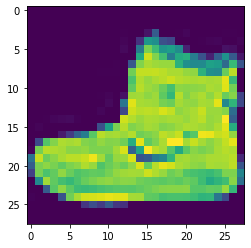

In [6]:
plt.imshow(Img[0][0].to(torch.device('cpu')).reshape(28,28));

In [64]:
sampler = torch.utils.data.RandomSampler(Img)

In [65]:
dataLoader = torch.utils.data.DataLoader(Img, sampler=sampler, batch_size=2000)

# Autoencoder

In [32]:
class AUTOENC(nn.Module):
    def __init__(self):
        super(AUTOENC, self).__init__()
#         a = 50
#         b = 100
#         c = 150
        a = 50
        b = 10
        c = 1
        
        self.conv10 = nn.Conv2d(1, a, 5)
        self.conv15 = nn.Conv2d(a, a, 5)
        self.conv20 = nn.Conv2d(a, b, 5)
        self.conv25 = nn.Conv2d(b, b, 5)
        self.conv30 = nn.Conv2d(b, c, 5)
        
        self.conv40 = nn.Conv2d(c, b, 5)
        self.conv45 = nn.Conv2d(b, b, 5)
        self.conv50 = nn.Conv2d(b, a, 5)
        self.conv55 = nn.Conv2d(a, a, 5)
        self.conv60 = nn.Conv2d(a, 1, 5)
        
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
    def forward(self, X):
        X = torch.relu(self.conv10(F.pad(X,(2,2,2,2))))

        X = torch.relu(self.conv15(F.pad(X,(2,2,2,2))))
        X, inda = self.pool(X)
        X = torch.relu(self.conv20(F.pad(X,(2,2,2,2))))
        
        X = torch.relu(self.conv25(F.pad(X,(2,2,2,2))))
        X, indb = self.pool(X)
        X = torch.relu(self.conv30(F.pad(X,(2,2,2,2))))
        
        X = torch.relu(self.conv40(F.pad(X,(2,2,2,2))))
        X = self.unpool(X, indb)
        X = torch.relu(self.conv45(F.pad(X,(2,2,2,2))))
        
        X = torch.relu(self.conv50(F.pad(X,(2,2,2,2))))
        X = self.unpool(X, inda)
        X = torch.relu(self.conv55(F.pad(X,(2,2,2,2))))
        
        X = torch.sigmoid(self.conv60(F.pad(X,(2,2,2,2))))
        
        return X

# Training

In [33]:
model = AUTOENC().to(device)

In [34]:
opt = optim.Adam(model.parameters(), lr=0.001)

In [35]:
EPOCHS=100
for epoch in range(EPOCHS):
    i = 1
    for X, y in tqdm_notebook(dataLoader):
        model.zero_grad()
        X_pred = model.forward(X)
        L = torch.sum((X - X_pred)**2)
        L.backward()
        opt.step()

        # Print
        if (i % (len(dataLoader)//10)) == 0: print("Iteration %d \n        L: %.4f" % (i, L))
        i += 1
        
        torch.cuda.empty_cache()

Iteration 3 
        L: 261879.0312
Iteration 6 
        L: 243626.3125
Iteration 9 
        L: 226470.1406
Iteration 12 
        L: 227216.1094
Iteration 15 
        L: 217862.7188
Iteration 18 
        L: 216677.1250
Iteration 21 
        L: 214350.4688
Iteration 24 
        L: 205679.2188
Iteration 27 
        L: 199486.2812
Iteration 30 
        L: 190547.7812
Iteration 33 
        L: 179151.9062



Iteration 3 
        L: 144623.8750
Iteration 6 
        L: 125512.6875
Iteration 9 
        L: 111393.4375
Iteration 12 
        L: 96879.6172
Iteration 15 
        L: 86855.8750
Iteration 18 
        L: 75250.6016
Iteration 21 
        L: 64313.3125
Iteration 24 
        L: 56880.2812
Iteration 27 
        L: 51410.0859
Iteration 30 
        L: 47668.1484
Iteration 33 
        L: 45206.0000



Iteration 3 
        L: 41513.6797
Iteration 6 
        L: 39560.9609
Iteration 9 
        L: 36347.6250
Iteration 12 
        L: 34235.1484
Iteration 15 
        L: 32109.8594
Iteration 18 
        L: 28280.9844
Iteration 21 
        L: 26342.0449
Iteration 24 
        L: 24583.8730
Iteration 27 
        L: 23118.5859
Iteration 30 
        L: 22159.4414
Iteration 33 
        L: 20653.3887



Iteration 3 
        L: 18872.2109
Iteration 6 
        L: 18451.7461
Iteration 9 
        L: 17743.0781
Iteration 12 
        L: 16931.8359
Iteration 15 
        L: 16397.8926
Iteration 18 
        L: 16043.1260
Iteration 21 
        L: 14982.7246
Iteration 24 
        L: 14801.3086
Iteration 27 
        L: 14443.2344
Iteration 30 
        L: 14207.7734
Iteration 33 
        L: 13875.1250



Iteration 3 
        L: 13132.3047
Iteration 6 
        L: 12788.0039
Iteration 9 
        L: 12561.9902
Iteration 12 
        L: 12532.9463
Iteration 15 
        L: 12457.4355
Iteration 18 
        L: 12351.6475
Iteration 21 
        L: 11797.5156
Iteration 24 
        L: 11959.7598
Iteration 27 
        L: 11595.0000
Iteration 30 
        L: 11405.9092
Iteration 33 
        L: 11390.5078



Iteration 3 
        L: 10815.4316
Iteration 6 
        L: 10916.2070
Iteration 9 
        L: 10691.9941
Iteration 12 
        L: 10925.0664
Iteration 15 
        L: 10664.6270
Iteration 18 
        L: 10689.9238
Iteration 21 
        L: 10528.1377
Iteration 24 
        L: 10385.9697
Iteration 27 
        L: 10290.1865
Iteration 30 
        L: 10235.2861
Iteration 33 
        L: 10415.1289



Iteration 3 
        L: 10807.5781
Iteration 6 
        L: 9793.7578
Iteration 9 
        L: 10284.6816
Iteration 12 
        L: 10063.9141
Iteration 15 
        L: 10017.8887
Iteration 18 
        L: 9724.6729
Iteration 21 
        L: 9652.9912
Iteration 24 
        L: 9655.8594
Iteration 27 
        L: 9589.7139
Iteration 30 
        L: 9335.7021
Iteration 33 
        L: 9326.9775



Iteration 3 
        L: 9201.3223
Iteration 6 
        L: 9122.4746
Iteration 9 
        L: 9205.5098
Iteration 12 
        L: 9078.0430
Iteration 15 
        L: 9006.8457
Iteration 18 
        L: 9199.6445
Iteration 21 
        L: 9091.7891
Iteration 24 
        L: 8942.0898
Iteration 27 
        L: 8773.9727
Iteration 30 
        L: 8851.7539
Iteration 33 
        L: 8651.0850



Iteration 3 
        L: 8977.5938
Iteration 6 
        L: 8622.8467
Iteration 9 
        L: 8609.5068
Iteration 12 
        L: 8759.7939
Iteration 15 
        L: 8500.4453
Iteration 18 
        L: 8591.8770
Iteration 21 
        L: 8423.0430
Iteration 24 
        L: 8488.7402
Iteration 27 
        L: 8256.3535
Iteration 30 
        L: 8264.5264
Iteration 33 
        L: 8573.6240



Iteration 3 
        L: 8289.1016
Iteration 6 
        L: 8609.3164
Iteration 9 
        L: 8139.2773
Iteration 12 
        L: 8684.8770
Iteration 15 
        L: 8037.2266
Iteration 18 
        L: 8537.4492
Iteration 21 
        L: 8007.5625
Iteration 24 
        L: 8472.8818
Iteration 27 
        L: 8068.1611
Iteration 30 
        L: 8086.2852
Iteration 33 
        L: 8185.3784



Iteration 3 
        L: 7933.5742
Iteration 6 
        L: 7866.3721
Iteration 9 
        L: 7851.2993
Iteration 12 
        L: 7847.9521
Iteration 15 
        L: 7696.5581
Iteration 18 
        L: 8022.9111
Iteration 21 
        L: 7712.7500
Iteration 24 
        L: 7650.9106
Iteration 27 
        L: 8282.8887
Iteration 30 
        L: 7572.4414
Iteration 33 
        L: 8016.0645



Iteration 3 
        L: 8154.1230
Iteration 6 
        L: 7644.3242
Iteration 9 
        L: 7311.3779
Iteration 12 
        L: 7568.8789
Iteration 15 
        L: 7512.3613
Iteration 18 
        L: 7385.2627
Iteration 21 
        L: 7338.7480
Iteration 24 
        L: 7443.9941
Iteration 27 
        L: 7299.2100
Iteration 30 
        L: 7145.5918
Iteration 33 
        L: 7566.9248



Iteration 3 
        L: 7402.2871
Iteration 6 
        L: 7142.6953
Iteration 9 
        L: 7193.6821
Iteration 12 
        L: 7070.8252
Iteration 15 
        L: 7058.1621
Iteration 18 
        L: 7162.0107
Iteration 21 
        L: 7049.4541
Iteration 24 
        L: 7027.5840
Iteration 27 
        L: 6970.9707
Iteration 30 
        L: 6856.8340
Iteration 33 
        L: 7014.1113



Iteration 3 
        L: 6888.0566
Iteration 6 
        L: 7141.4707
Iteration 9 
        L: 6922.4429
Iteration 12 
        L: 6809.8535
Iteration 15 
        L: 6741.9663
Iteration 18 
        L: 6823.4482
Iteration 21 
        L: 6664.5303
Iteration 24 
        L: 6597.7266
Iteration 27 
        L: 6662.4927
Iteration 30 
        L: 6997.1758
Iteration 33 
        L: 7064.6475



Iteration 3 
        L: 7067.3364
Iteration 6 
        L: 6669.9307
Iteration 9 
        L: 6910.0840
Iteration 12 
        L: 6674.1299
Iteration 15 
        L: 6665.2095
Iteration 18 
        L: 6466.0444
Iteration 21 
        L: 6608.7759
Iteration 24 
        L: 6697.9858
Iteration 27 
        L: 6447.8252
Iteration 30 
        L: 6613.1875
Iteration 33 
        L: 6408.6582



Iteration 3 
        L: 6436.8477
Iteration 6 
        L: 6493.9551
Iteration 9 
        L: 6301.1060
Iteration 12 
        L: 6322.9424
Iteration 15 
        L: 6315.2275
Iteration 18 
        L: 6208.4961
Iteration 21 
        L: 6350.9785
Iteration 24 
        L: 6348.2627
Iteration 27 
        L: 6215.5142
Iteration 30 
        L: 6168.6592
Iteration 33 
        L: 6132.3086



Iteration 3 
        L: 6708.2231
Iteration 6 
        L: 6889.4575
Iteration 9 
        L: 6096.0791
Iteration 12 
        L: 6447.6929
Iteration 15 
        L: 6132.0391
Iteration 18 
        L: 6239.4365
Iteration 21 
        L: 6130.4214
Iteration 24 
        L: 6137.8154
Iteration 27 
        L: 5984.4844
Iteration 30 
        L: 6128.8682
Iteration 33 
        L: 6125.1431



Iteration 3 
        L: 5901.5532
Iteration 6 
        L: 6232.7090
Iteration 9 
        L: 6146.8154
Iteration 12 
        L: 6002.2510
Iteration 15 
        L: 5850.7432
Iteration 18 
        L: 6200.1064
Iteration 21 
        L: 6088.0205
Iteration 24 
        L: 5958.3174
Iteration 27 
        L: 6466.7583
Iteration 30 
        L: 5948.5830
Iteration 33 
        L: 6008.4727



Iteration 3 
        L: 6060.3809
Iteration 6 
        L: 5932.6577
Iteration 9 
        L: 6103.7207
Iteration 12 
        L: 6040.2314
Iteration 15 
        L: 6015.9404
Iteration 18 
        L: 5758.0479
Iteration 21 
        L: 6052.4795
Iteration 24 
        L: 5767.2197
Iteration 27 
        L: 6078.3584
Iteration 30 
        L: 5897.4883
Iteration 33 
        L: 5816.8711



Iteration 3 
        L: 5752.4961
Iteration 6 
        L: 5941.2827
Iteration 9 
        L: 5761.1084
Iteration 12 
        L: 5856.3760
Iteration 15 
        L: 5666.9155
Iteration 18 
        L: 5753.4106
Iteration 21 
        L: 5629.9399
Iteration 24 
        L: 5675.2114
Iteration 27 
        L: 5731.7925
Iteration 30 
        L: 5761.2451
Iteration 33 
        L: 5609.4805



Iteration 3 
        L: 5628.7344
Iteration 6 
        L: 5652.0059
Iteration 9 
        L: 5723.9131
Iteration 12 
        L: 5585.0537
Iteration 15 
        L: 5648.0674
Iteration 18 
        L: 5809.6699
Iteration 21 
        L: 6020.1377
Iteration 24 
        L: 5651.8403
Iteration 27 
        L: 5601.8389
Iteration 30 
        L: 5970.4741
Iteration 33 
        L: 5614.9482



Iteration 3 
        L: 5628.6064
Iteration 6 
        L: 5586.9102
Iteration 9 
        L: 5512.5278
Iteration 12 
        L: 5741.4814
Iteration 15 
        L: 5477.2852
Iteration 18 
        L: 5489.7666
Iteration 21 
        L: 5451.3149
Iteration 24 
        L: 5585.0073
Iteration 27 
        L: 5586.4414
Iteration 30 
        L: 5483.0762
Iteration 33 
        L: 5896.8848



Iteration 3 
        L: 5500.6123
Iteration 6 
        L: 5607.6338
Iteration 9 
        L: 5379.9580
Iteration 12 
        L: 5371.0347
Iteration 15 
        L: 5400.5498
Iteration 18 
        L: 5579.0000
Iteration 21 
        L: 5288.8564
Iteration 24 
        L: 5685.2422
Iteration 27 
        L: 5332.5791
Iteration 30 
        L: 5895.3662
Iteration 33 
        L: 5501.1431



Iteration 3 
        L: 5575.9912
Iteration 6 
        L: 5326.8638
Iteration 9 
        L: 5273.7788
Iteration 12 
        L: 5638.3262
Iteration 15 
        L: 5351.0063
Iteration 18 
        L: 5351.2983
Iteration 21 
        L: 5238.5806
Iteration 24 
        L: 5269.0703
Iteration 27 
        L: 5232.1167
Iteration 30 
        L: 5248.2056
Iteration 33 
        L: 5158.1494



Iteration 3 
        L: 5280.3696
Iteration 6 
        L: 5240.9502
Iteration 9 
        L: 5304.3320
Iteration 12 
        L: 5431.7046
Iteration 15 
        L: 5175.3086
Iteration 18 
        L: 5585.5078
Iteration 21 
        L: 5273.0615
Iteration 24 
        L: 5245.2490
Iteration 27 
        L: 5257.2314
Iteration 30 
        L: 5214.1162
Iteration 33 
        L: 5179.0762



Iteration 3 
        L: 5208.8379
Iteration 6 
        L: 5280.6836
Iteration 9 
        L: 5352.0762
Iteration 12 
        L: 5199.4834
Iteration 15 
        L: 5263.0859
Iteration 18 
        L: 5263.4414
Iteration 21 
        L: 5070.8291
Iteration 24 
        L: 5103.8838
Iteration 27 
        L: 5157.4707
Iteration 30 
        L: 5103.7100
Iteration 33 
        L: 5188.3569



Iteration 3 
        L: 5401.6489
Iteration 6 
        L: 5059.5664
Iteration 9 
        L: 5185.9307
Iteration 12 
        L: 5152.5815
Iteration 15 
        L: 5090.6904
Iteration 18 
        L: 5300.7451
Iteration 21 
        L: 5121.2500
Iteration 24 
        L: 5234.0469
Iteration 27 
        L: 5044.3369
Iteration 30 
        L: 5245.4199
Iteration 33 
        L: 5166.8232



Iteration 3 
        L: 5126.4463
Iteration 6 
        L: 5237.9111
Iteration 9 
        L: 5075.0513
Iteration 12 
        L: 4974.5098
Iteration 15 
        L: 5092.0674
Iteration 18 
        L: 5084.3901
Iteration 21 
        L: 5014.9551
Iteration 24 
        L: 4962.9385
Iteration 27 
        L: 5386.9126
Iteration 30 
        L: 5071.6792
Iteration 33 
        L: 5086.5967



Iteration 3 
        L: 5017.8315
Iteration 6 
        L: 4970.1680
Iteration 9 
        L: 5033.2637
Iteration 12 
        L: 5667.6230
Iteration 15 
        L: 5230.4614
Iteration 18 
        L: 5264.5371
Iteration 21 
        L: 5189.5015
Iteration 24 
        L: 5315.8135
Iteration 27 
        L: 4865.7222
Iteration 30 
        L: 5009.1914
Iteration 33 
        L: 4916.2529



Iteration 3 
        L: 4941.7139
Iteration 6 
        L: 4985.9316
Iteration 9 
        L: 4889.7603
Iteration 12 
        L: 5022.9688
Iteration 15 
        L: 4902.7354
Iteration 18 
        L: 4964.6211
Iteration 21 
        L: 4927.9224
Iteration 24 
        L: 4924.3462
Iteration 27 
        L: 5084.2100
Iteration 30 
        L: 4881.5693
Iteration 33 
        L: 4878.6343



Iteration 3 
        L: 4888.4849
Iteration 6 
        L: 4842.2773
Iteration 9 
        L: 4900.9258
Iteration 12 
        L: 4828.1367
Iteration 15 
        L: 4812.3271
Iteration 18 
        L: 4857.8423
Iteration 21 
        L: 4798.1494
Iteration 24 
        L: 4795.6270
Iteration 27 
        L: 4849.5547
Iteration 30 
        L: 4892.3711
Iteration 33 
        L: 4949.3389



Iteration 3 
        L: 5036.1279
Iteration 6 
        L: 4909.9756
Iteration 9 
        L: 4757.3755
Iteration 12 
        L: 4779.6221
Iteration 15 
        L: 4757.9067
Iteration 18 
        L: 4778.6714
Iteration 21 
        L: 4861.9639
Iteration 24 
        L: 4961.5850
Iteration 27 
        L: 5191.6431
Iteration 30 
        L: 5101.0063
Iteration 33 
        L: 4921.3560



Iteration 3 
        L: 4944.8286
Iteration 6 
        L: 4788.5156
Iteration 9 
        L: 4963.1592
Iteration 12 
        L: 4730.5928
Iteration 15 
        L: 4899.1553
Iteration 18 
        L: 4721.4282
Iteration 21 
        L: 4777.4629
Iteration 24 
        L: 4765.9795
Iteration 27 
        L: 4722.0942
Iteration 30 
        L: 4770.3369
Iteration 33 
        L: 4877.8555



Iteration 3 
        L: 4824.0029
Iteration 6 
        L: 5335.4497
Iteration 9 
        L: 4997.7749
Iteration 12 
        L: 4946.6357
Iteration 15 
        L: 5095.9609
Iteration 18 
        L: 4690.1152
Iteration 21 
        L: 4748.7456
Iteration 24 
        L: 4664.5264
Iteration 27 
        L: 4796.4214
Iteration 30 
        L: 4702.8208
Iteration 33 
        L: 4674.3276



Iteration 3 
        L: 4809.9941
Iteration 6 
        L: 4682.1299
Iteration 9 
        L: 4685.5029
Iteration 12 
        L: 4797.1572
Iteration 15 
        L: 4720.0273
Iteration 18 
        L: 4748.4521
Iteration 21 
        L: 4864.8721
Iteration 24 
        L: 4598.4287
Iteration 27 
        L: 4682.9795
Iteration 30 
        L: 4849.5601
Iteration 33 
        L: 4645.0474



Iteration 3 
        L: 4702.0972
Iteration 6 
        L: 4764.9346
Iteration 9 
        L: 4654.9561
Iteration 12 
        L: 4621.4331
Iteration 15 
        L: 4635.9990
Iteration 18 
        L: 4940.0298
Iteration 21 
        L: 4601.9839
Iteration 24 
        L: 4835.3154
Iteration 27 
        L: 4790.7021
Iteration 30 
        L: 4737.0527
Iteration 33 
        L: 5015.2612



Iteration 3 
        L: 4706.6992
Iteration 6 
        L: 4593.2812
Iteration 9 
        L: 5248.7842
Iteration 12 
        L: 4533.4521
Iteration 15 
        L: 4676.4048
Iteration 18 
        L: 4586.2417
Iteration 21 
        L: 5013.4326
Iteration 24 
        L: 4537.6455
Iteration 27 
        L: 5079.6807
Iteration 30 
        L: 4845.4595
Iteration 33 
        L: 4735.7842



Iteration 3 
        L: 4608.4258
Iteration 6 
        L: 4795.6782
Iteration 9 
        L: 4919.5518
Iteration 12 
        L: 4440.3535
Iteration 15 
        L: 4665.3311
Iteration 18 
        L: 4620.8770
Iteration 21 
        L: 4471.8354
Iteration 24 
        L: 4621.6519
Iteration 27 
        L: 4532.9028
Iteration 30 
        L: 4510.8159
Iteration 33 
        L: 4756.6411



Iteration 3 
        L: 4515.6890
Iteration 6 
        L: 4562.6602
Iteration 9 
        L: 4539.3643
Iteration 12 
        L: 4540.3281
Iteration 15 
        L: 4555.7510
Iteration 18 
        L: 4502.7666
Iteration 21 
        L: 4604.3706
Iteration 24 
        L: 4572.0415
Iteration 27 
        L: 4450.3730
Iteration 30 
        L: 4584.8120
Iteration 33 
        L: 4646.5928



Iteration 3 
        L: 4678.6201
Iteration 6 
        L: 4625.7700
Iteration 9 
        L: 4562.8730
Iteration 12 
        L: 4485.3530
Iteration 15 
        L: 4503.0718
Iteration 18 
        L: 4462.4868
Iteration 21 
        L: 4469.4521
Iteration 24 
        L: 4476.8096
Iteration 27 
        L: 4473.3506
Iteration 30 
        L: 4444.5352
Iteration 33 
        L: 4442.3613



Iteration 3 
        L: 4561.2100
Iteration 6 
        L: 4754.6875
Iteration 9 
        L: 4390.5088
Iteration 12 
        L: 4609.5186
Iteration 15 
        L: 4549.3535
Iteration 18 
        L: 4470.1455
Iteration 21 
        L: 4571.3101
Iteration 24 
        L: 4416.8555
Iteration 27 
        L: 4472.9980
Iteration 30 
        L: 4706.0903
Iteration 33 
        L: 4775.5142



Iteration 3 
        L: 4761.3564
Iteration 6 
        L: 4407.8340
Iteration 9 
        L: 4669.9463
Iteration 12 
        L: 4456.5391
Iteration 15 
        L: 4492.3354
Iteration 18 
        L: 4373.9199
Iteration 21 
        L: 4567.5693
Iteration 24 
        L: 4680.4893
Iteration 27 
        L: 4518.4014
Iteration 30 
        L: 4455.3467
Iteration 33 
        L: 4625.0449



Iteration 3 
        L: 4472.3164
Iteration 6 
        L: 4322.7500
Iteration 9 
        L: 4541.7515
Iteration 12 
        L: 4348.6455
Iteration 15 
        L: 4479.2070
Iteration 18 
        L: 4422.2891
Iteration 21 
        L: 4653.0840
Iteration 24 
        L: 4385.5327
Iteration 27 
        L: 4527.8076
Iteration 30 
        L: 4438.8740
Iteration 33 
        L: 4570.0322



Iteration 3 
        L: 4377.6753
Iteration 6 
        L: 4367.1729
Iteration 9 
        L: 4550.1689
Iteration 12 
        L: 4388.3242
Iteration 15 
        L: 4471.4766
Iteration 18 
        L: 4512.1831
Iteration 21 
        L: 4362.9478
Iteration 24 
        L: 4481.5020
Iteration 27 
        L: 4269.3208
Iteration 30 
        L: 4669.5649
Iteration 33 
        L: 4313.4268



Iteration 3 
        L: 4496.5518
Iteration 6 
        L: 4427.3677
Iteration 9 
        L: 4658.4546
Iteration 12 
        L: 4287.2539
Iteration 15 
        L: 4424.6631
Iteration 18 
        L: 4325.3516
Iteration 21 
        L: 4337.7695
Iteration 24 
        L: 4415.1069
Iteration 27 
        L: 4229.4795
Iteration 30 
        L: 4434.3032
Iteration 33 
        L: 4266.1104



Iteration 3 
        L: 4673.0068
Iteration 6 
        L: 4345.4395
Iteration 9 
        L: 4361.4590
Iteration 12 
        L: 4471.4385
Iteration 15 
        L: 4294.1890
Iteration 18 
        L: 4355.1611
Iteration 21 
        L: 4268.5029
Iteration 24 
        L: 4321.9414
Iteration 27 
        L: 4300.3721
Iteration 30 
        L: 4233.7539
Iteration 33 
        L: 4277.1860



Iteration 3 
        L: 4253.5156
Iteration 6 
        L: 4244.5879
Iteration 9 
        L: 4204.6123
Iteration 12 
        L: 4128.4307
Iteration 15 
        L: 4245.4521
Iteration 18 
        L: 4254.4854
Iteration 21 
        L: 4302.8457
Iteration 24 
        L: 4262.8457
Iteration 27 
        L: 4247.9360
Iteration 30 
        L: 4302.6250
Iteration 33 
        L: 4406.7388



Iteration 3 
        L: 4302.5596
Iteration 6 
        L: 4231.3867
Iteration 9 
        L: 4320.6816
Iteration 12 
        L: 4310.1982
Iteration 15 
        L: 4308.8091
Iteration 18 
        L: 4207.4717
Iteration 21 
        L: 4464.2695
Iteration 24 
        L: 4635.2124
Iteration 27 
        L: 4291.7891
Iteration 30 
        L: 4333.6177
Iteration 33 
        L: 4207.1294



Iteration 3 
        L: 4224.8789
Iteration 6 
        L: 4225.7466
Iteration 9 
        L: 4299.7461
Iteration 12 
        L: 4555.3545
Iteration 15 
        L: 4180.8311
Iteration 18 
        L: 4698.0830
Iteration 21 
        L: 4913.0635
Iteration 24 
        L: 4321.7598
Iteration 27 
        L: 4408.3076
Iteration 30 
        L: 4596.2383
Iteration 33 
        L: 4243.8721



Iteration 3 
        L: 4319.0410
Iteration 6 
        L: 4128.8716
Iteration 9 
        L: 4342.8154
Iteration 12 
        L: 4303.8296
Iteration 15 
        L: 4168.6025
Iteration 18 
        L: 4177.0571
Iteration 21 
        L: 4180.4170
Iteration 24 
        L: 4104.9731
Iteration 27 
        L: 4157.8525
Iteration 30 
        L: 4141.9912
Iteration 33 
        L: 4175.7246



Iteration 3 
        L: 4174.2183
Iteration 6 
        L: 4156.2373
Iteration 9 
        L: 4282.9429
Iteration 12 
        L: 4108.8994
Iteration 15 
        L: 4152.5869
Iteration 18 
        L: 4076.1753
Iteration 21 
        L: 4183.9912
Iteration 24 
        L: 4466.9668
Iteration 27 
        L: 4148.4551
Iteration 30 
        L: 4322.2319
Iteration 33 
        L: 4112.1875



Iteration 3 
        L: 4126.6230
Iteration 6 
        L: 4229.3779
Iteration 9 
        L: 4173.0630
Iteration 12 
        L: 4189.8564
Iteration 15 
        L: 4095.2573
Iteration 18 
        L: 4149.9419
Iteration 21 
        L: 4179.8086
Iteration 24 
        L: 4126.4858
Iteration 27 
        L: 4126.9077
Iteration 30 
        L: 4204.2393
Iteration 33 
        L: 4127.5371



Iteration 3 
        L: 4063.9771
Iteration 6 
        L: 4219.4766
Iteration 9 
        L: 4202.5972
Iteration 12 
        L: 4068.2661
Iteration 15 
        L: 4173.9941
Iteration 18 
        L: 4095.1194
Iteration 21 
        L: 4063.3564
Iteration 24 
        L: 4087.0520
Iteration 27 
        L: 4010.6638
Iteration 30 
        L: 4168.0586
Iteration 33 
        L: 4760.6685



Iteration 3 
        L: 4131.9092
Iteration 6 
        L: 4244.3940
Iteration 9 
        L: 4093.4495
Iteration 12 
        L: 4090.1201
Iteration 15 
        L: 4132.4141
Iteration 18 
        L: 4130.3535
Iteration 21 
        L: 4369.9658
Iteration 24 
        L: 4182.9873
Iteration 27 
        L: 4074.7539
Iteration 30 
        L: 4068.5972
Iteration 33 
        L: 4139.0591



Iteration 3 
        L: 4055.8960
Iteration 6 
        L: 3997.3154
Iteration 9 
        L: 4058.8496
Iteration 12 
        L: 4038.2778
Iteration 15 
        L: 4054.9707
Iteration 18 
        L: 4189.2510
Iteration 21 
        L: 4878.6689
Iteration 24 
        L: 4116.0283
Iteration 27 
        L: 4171.8394
Iteration 30 
        L: 4096.3984
Iteration 33 
        L: 4049.2554



Iteration 3 
        L: 4077.8296
Iteration 6 
        L: 3987.7612
Iteration 9 
        L: 4083.6682
Iteration 12 
        L: 4050.2168
Iteration 15 
        L: 4125.4141
Iteration 18 
        L: 4289.3867
Iteration 21 
        L: 4062.0156
Iteration 24 
        L: 4045.7832
Iteration 27 
        L: 4105.6758
Iteration 30 
        L: 4349.3633
Iteration 33 
        L: 4245.4185



Iteration 3 
        L: 4221.3857
Iteration 6 
        L: 3965.2734
Iteration 9 
        L: 4089.1836
Iteration 12 
        L: 4112.3115
Iteration 15 
        L: 3989.1904
Iteration 18 
        L: 3955.0903
Iteration 21 
        L: 3927.7620
Iteration 24 
        L: 4102.7803
Iteration 27 
        L: 4016.3655
Iteration 30 
        L: 4059.0388
Iteration 33 
        L: 4126.7397



Iteration 3 
        L: 4060.9988
Iteration 6 
        L: 4002.1895
Iteration 9 
        L: 4029.0916
Iteration 12 
        L: 3968.7529
Iteration 15 
        L: 3967.4199
Iteration 18 
        L: 4101.3398
Iteration 21 
        L: 4275.8135
Iteration 24 
        L: 4037.3328
Iteration 27 
        L: 4080.9385
Iteration 30 
        L: 4173.3672
Iteration 33 
        L: 4007.0518



Iteration 3 
        L: 4079.3530
Iteration 6 
        L: 3944.3975
Iteration 9 
        L: 4451.0439
Iteration 12 
        L: 4177.5264
Iteration 15 
        L: 4186.4277
Iteration 18 
        L: 4005.0596
Iteration 21 
        L: 4107.7256
Iteration 24 
        L: 4035.7622
Iteration 27 
        L: 3955.7134
Iteration 30 
        L: 3994.9771
Iteration 33 
        L: 3894.4822



Iteration 3 
        L: 3936.8457
Iteration 6 
        L: 3993.3091
Iteration 9 
        L: 3922.7869
Iteration 12 
        L: 4027.8188
Iteration 15 
        L: 3950.7930
Iteration 18 
        L: 4099.8984
Iteration 21 
        L: 4299.5913
Iteration 24 
        L: 3961.0730
Iteration 27 
        L: 4145.9316
Iteration 30 
        L: 3918.6091
Iteration 33 
        L: 4037.9619



Iteration 3 
        L: 3948.0303
Iteration 6 
        L: 3946.2693
Iteration 9 
        L: 4038.1709
Iteration 12 
        L: 4091.8711
Iteration 15 
        L: 3877.0327
Iteration 18 
        L: 3974.6458
Iteration 21 
        L: 3910.5088
Iteration 24 
        L: 3933.0830
Iteration 27 
        L: 3845.8738
Iteration 30 
        L: 3961.4104
Iteration 33 
        L: 3960.3774



Iteration 3 
        L: 3938.9097
Iteration 6 
        L: 4002.0879
Iteration 9 
        L: 4078.7109
Iteration 12 
        L: 3831.3079
Iteration 15 
        L: 3938.2229
Iteration 18 
        L: 3956.6987
Iteration 21 
        L: 4091.5454
Iteration 24 
        L: 4102.4287
Iteration 27 
        L: 4115.9277
Iteration 30 
        L: 3874.9492
Iteration 33 
        L: 3923.1375



Iteration 3 
        L: 3969.4355
Iteration 6 
        L: 3860.6211
Iteration 9 
        L: 3857.9878
Iteration 12 
        L: 3879.4392
Iteration 15 
        L: 4003.6648
Iteration 18 
        L: 3949.0649
Iteration 21 
        L: 4287.2627
Iteration 24 
        L: 4346.2959
Iteration 27 
        L: 3842.8564
Iteration 30 
        L: 4103.7168
Iteration 33 
        L: 3976.5728



Iteration 3 
        L: 3875.9905
Iteration 6 
        L: 3934.8564
Iteration 9 
        L: 3861.6226
Iteration 12 
        L: 3942.2222
Iteration 15 
        L: 3946.1067
Iteration 18 
        L: 3916.3442
Iteration 21 
        L: 3907.2246
Iteration 24 
        L: 3917.4014
Iteration 27 
        L: 4140.5806
Iteration 30 
        L: 3827.8562
Iteration 33 
        L: 4009.0684



Iteration 3 
        L: 3818.4312
Iteration 6 
        L: 3942.7480
Iteration 9 
        L: 3913.4585
Iteration 12 
        L: 3880.2656
Iteration 15 
        L: 3976.0154
Iteration 18 
        L: 3852.5203
Iteration 21 
        L: 3820.0400
Iteration 24 
        L: 3945.5898
Iteration 27 
        L: 4094.3645
Iteration 30 
        L: 4072.0908
Iteration 33 
        L: 3876.7632



Iteration 3 
        L: 4023.2275
Iteration 6 
        L: 3892.6514
Iteration 9 
        L: 3862.9353
Iteration 12 
        L: 3944.4160
Iteration 15 
        L: 3952.0930
Iteration 18 
        L: 3815.2676
Iteration 21 
        L: 3865.0896
Iteration 24 
        L: 3901.4211
Iteration 27 
        L: 3875.0903
Iteration 30 
        L: 4244.4150
Iteration 33 
        L: 3874.8735



Iteration 3 
        L: 4046.0400
Iteration 6 
        L: 3857.7271
Iteration 9 
        L: 4073.9697
Iteration 12 
        L: 3836.4417
Iteration 15 
        L: 3924.3252
Iteration 18 
        L: 3803.6235
Iteration 21 
        L: 3924.5293
Iteration 24 
        L: 3864.4834
Iteration 27 
        L: 3779.3975
Iteration 30 
        L: 3846.1245
Iteration 33 
        L: 3862.1753



Iteration 3 
        L: 3803.6123
Iteration 6 
        L: 4160.7368
Iteration 9 
        L: 4122.7158
Iteration 12 
        L: 3819.1006
Iteration 15 
        L: 3984.0767
Iteration 18 
        L: 3739.6396
Iteration 21 
        L: 3804.8105
Iteration 24 
        L: 3827.3313
Iteration 27 
        L: 3857.8877
Iteration 30 
        L: 3745.9446
Iteration 33 
        L: 3886.9077



Iteration 3 
        L: 3768.2617
Iteration 6 
        L: 3830.3110
Iteration 9 
        L: 3887.3411
Iteration 12 
        L: 3771.1096
Iteration 15 
        L: 3815.2783
Iteration 18 
        L: 3981.4236
Iteration 21 
        L: 3890.4651
Iteration 24 
        L: 3795.6301
Iteration 27 
        L: 3826.9053
Iteration 30 
        L: 3762.9246
Iteration 33 
        L: 4335.3545



Iteration 3 
        L: 3800.9692
Iteration 6 
        L: 3816.4834
Iteration 9 
        L: 3802.1392
Iteration 12 
        L: 3809.0667
Iteration 15 
        L: 4337.8721
Iteration 18 
        L: 3741.1050
Iteration 21 
        L: 4218.6025
Iteration 24 
        L: 3760.9045
Iteration 27 
        L: 4061.4448
Iteration 30 
        L: 3860.5291
Iteration 33 
        L: 3791.7153



Iteration 3 
        L: 3781.0654
Iteration 6 
        L: 3752.5469
Iteration 9 
        L: 3816.7180
Iteration 12 
        L: 3773.6724
Iteration 15 
        L: 3755.9414
Iteration 18 
        L: 3813.9146
Iteration 21 
        L: 3739.8022
Iteration 24 
        L: 3814.0759
Iteration 27 
        L: 3796.6821
Iteration 30 
        L: 3808.3677
Iteration 33 
        L: 3712.4243



Iteration 3 
        L: 4211.0488
Iteration 6 
        L: 3910.6938
Iteration 9 
        L: 3718.1177
Iteration 12 
        L: 3749.6919
Iteration 15 
        L: 3795.6294
Iteration 18 
        L: 3715.7810
Iteration 21 
        L: 3819.3582
Iteration 24 
        L: 3765.3350
Iteration 27 
        L: 3704.2336
Iteration 30 
        L: 3691.8225
Iteration 33 
        L: 3846.6514



Iteration 3 
        L: 3784.8215
Iteration 6 
        L: 3863.2144
Iteration 9 
        L: 3805.7493
Iteration 12 
        L: 3812.5439
Iteration 15 
        L: 3708.5032
Iteration 18 
        L: 3721.1265
Iteration 21 
        L: 3714.4736
Iteration 24 
        L: 3790.9634
Iteration 27 
        L: 3969.9346
Iteration 30 
        L: 3989.7405
Iteration 33 
        L: 3883.5430



Iteration 3 
        L: 3741.0117
Iteration 6 
        L: 3741.4856
Iteration 9 
        L: 3701.9717
Iteration 12 
        L: 3723.1914
Iteration 15 
        L: 3938.9209
Iteration 18 
        L: 3881.0640
Iteration 21 
        L: 3813.2646
Iteration 24 
        L: 3686.8794
Iteration 27 
        L: 4000.0757
Iteration 30 
        L: 3829.1265
Iteration 33 
        L: 3697.8760



Iteration 3 
        L: 3739.9722
Iteration 6 
        L: 3732.5500
Iteration 9 
        L: 3709.2095
Iteration 12 
        L: 3822.5879
Iteration 15 
        L: 3782.4468
Iteration 18 
        L: 3695.9570
Iteration 21 
        L: 3769.8301
Iteration 24 
        L: 3808.9062
Iteration 27 
        L: 3636.6870
Iteration 30 
        L: 3766.0022
Iteration 33 
        L: 3735.6445



Iteration 3 
        L: 3934.3013
Iteration 6 
        L: 3906.8887
Iteration 9 
        L: 3698.1504
Iteration 12 
        L: 3856.1909
Iteration 15 
        L: 3617.9688
Iteration 18 
        L: 3645.9492
Iteration 21 
        L: 3683.5854
Iteration 24 
        L: 3692.6616
Iteration 27 
        L: 3702.3103
Iteration 30 
        L: 3803.4810
Iteration 33 
        L: 3689.4399



Iteration 3 
        L: 3661.9282
Iteration 6 
        L: 3657.6294
Iteration 9 
        L: 3622.7266
Iteration 12 
        L: 3679.0273
Iteration 15 
        L: 3688.8232
Iteration 18 
        L: 3741.8132
Iteration 21 
        L: 3832.0740
Iteration 24 
        L: 4051.8857
Iteration 27 
        L: 4042.2056
Iteration 30 
        L: 3671.9810
Iteration 33 
        L: 3892.5701



Iteration 3 
        L: 3685.9946
Iteration 6 
        L: 3673.1709
Iteration 9 
        L: 3666.6133
Iteration 12 
        L: 3761.9285
Iteration 15 
        L: 3637.2820
Iteration 18 
        L: 3660.5098
Iteration 21 
        L: 3775.7878
Iteration 24 
        L: 3712.9727
Iteration 27 
        L: 3745.6538
Iteration 30 
        L: 3673.1123
Iteration 33 
        L: 3778.5479



Iteration 3 
        L: 3855.3872
Iteration 6 
        L: 3659.6675
Iteration 9 
        L: 3972.6892
Iteration 12 
        L: 3815.3979
Iteration 15 
        L: 4025.2793
Iteration 18 
        L: 3703.9824
Iteration 21 
        L: 3767.3179
Iteration 24 
        L: 3635.6934
Iteration 27 
        L: 3688.7661
Iteration 30 
        L: 3614.5530
Iteration 33 
        L: 3682.1855



Iteration 3 
        L: 3673.7534
Iteration 6 
        L: 3746.7751
Iteration 9 
        L: 3699.3130
Iteration 12 
        L: 3616.3215
Iteration 15 
        L: 3663.9470
Iteration 18 
        L: 3643.6602
Iteration 21 
        L: 3667.7656
Iteration 24 
        L: 3702.3472
Iteration 27 
        L: 3868.0374
Iteration 30 
        L: 3807.2993
Iteration 33 
        L: 3656.7454



Iteration 3 
        L: 3675.8655
Iteration 6 
        L: 3693.7864
Iteration 9 
        L: 3751.2295
Iteration 12 
        L: 3664.4136
Iteration 15 
        L: 3747.0510
Iteration 18 
        L: 3690.5938
Iteration 21 
        L: 3606.8748
Iteration 24 
        L: 3744.2927
Iteration 27 
        L: 3672.4314
Iteration 30 
        L: 3814.0757
Iteration 33 
        L: 3891.5054



Iteration 3 
        L: 3725.3237
Iteration 6 
        L: 3654.4644
Iteration 9 
        L: 3756.7002
Iteration 12 
        L: 3651.4514
Iteration 15 
        L: 3559.6670
Iteration 18 
        L: 3598.8682
Iteration 21 
        L: 3713.8945
Iteration 24 
        L: 3586.4673
Iteration 27 
        L: 3737.2466
Iteration 30 
        L: 3758.6589
Iteration 33 
        L: 3646.7666



Iteration 3 
        L: 3555.3110
Iteration 6 
        L: 3678.3909
Iteration 9 
        L: 3621.5835
Iteration 12 
        L: 3579.4941
Iteration 15 
        L: 3655.2949
Iteration 18 
        L: 3713.2129
Iteration 21 
        L: 3799.5452
Iteration 24 
        L: 3719.7354
Iteration 27 
        L: 3590.3638
Iteration 30 
        L: 3639.4824
Iteration 33 
        L: 3730.3867



Iteration 3 
        L: 3627.6768
Iteration 6 
        L: 3690.3047
Iteration 9 
        L: 3743.0522
Iteration 12 
        L: 4060.4268
Iteration 15 
        L: 3672.8767
Iteration 18 
        L: 3711.9961
Iteration 21 
        L: 3569.9131
Iteration 24 
        L: 3666.7095
Iteration 27 
        L: 3630.1958
Iteration 30 
        L: 3637.5596
Iteration 33 
        L: 3658.5432



Iteration 3 
        L: 3783.3931
Iteration 6 
        L: 3582.9612
Iteration 9 
        L: 3731.1956
Iteration 12 
        L: 3784.7385
Iteration 15 
        L: 3563.5898
Iteration 18 
        L: 3763.9285
Iteration 21 
        L: 3586.9128
Iteration 24 
        L: 3767.2017
Iteration 27 
        L: 3588.6665
Iteration 30 
        L: 3932.8174
Iteration 33 
        L: 3619.6245



Iteration 3 
        L: 3593.2764
Iteration 6 
        L: 3571.1543
Iteration 9 
        L: 3563.5750
Iteration 12 
        L: 3561.1865
Iteration 15 
        L: 3582.7139
Iteration 18 
        L: 3636.5093
Iteration 21 
        L: 3774.4084
Iteration 24 
        L: 3540.7466
Iteration 27 
        L: 3548.8901
Iteration 30 
        L: 3628.3159
Iteration 33 
        L: 3672.2654



Iteration 3 
        L: 3658.7249
Iteration 6 
        L: 3694.0784
Iteration 9 
        L: 3609.1143
Iteration 12 
        L: 3570.2874
Iteration 15 
        L: 3556.4355
Iteration 18 
        L: 3687.7126
Iteration 21 
        L: 3618.2727
Iteration 24 
        L: 3631.4990
Iteration 27 
        L: 3887.1155
Iteration 30 
        L: 3739.2891
Iteration 33 
        L: 3557.9221



Iteration 3 
        L: 3619.0542
Iteration 6 
        L: 3572.5024
Iteration 9 
        L: 3576.2825
Iteration 12 
        L: 3555.0542
Iteration 15 
        L: 3590.5566
Iteration 18 
        L: 3931.9448
Iteration 21 
        L: 3496.2144
Iteration 24 
        L: 3630.0918
Iteration 27 
        L: 3474.9951
Iteration 30 
        L: 3552.2852
Iteration 33 
        L: 3521.7080



Iteration 3 
        L: 3528.2676
Iteration 6 
        L: 3622.4526
Iteration 9 
        L: 3571.6375
Iteration 12 
        L: 3594.1565
Iteration 15 
        L: 3560.2166
Iteration 18 
        L: 3553.9155
Iteration 21 
        L: 3560.7981
Iteration 24 
        L: 3502.9548
Iteration 27 
        L: 3516.5681
Iteration 30 
        L: 3583.1941
Iteration 33 
        L: 3644.6721



Iteration 3 
        L: 3537.9927
Iteration 6 
        L: 3700.6123
Iteration 9 
        L: 3835.1675
Iteration 12 
        L: 3535.1660
Iteration 15 
        L: 3474.0154
Iteration 18 
        L: 3575.2344
Iteration 21 
        L: 4008.3066
Iteration 24 
        L: 4068.1812
Iteration 27 
        L: 3520.6189
Iteration 30 
        L: 3704.4429
Iteration 33 
        L: 3616.1677



Iteration 3 
        L: 3569.1638
Iteration 6 
        L: 3751.2271
Iteration 9 
        L: 3677.1069
Iteration 12 
        L: 3551.0649
Iteration 15 
        L: 3851.6841
Iteration 18 
        L: 3523.9172
Iteration 21 
        L: 3582.7368
Iteration 24 
        L: 3619.6826
Iteration 27 
        L: 3533.1387
Iteration 30 
        L: 3575.2009
Iteration 33 
        L: 3566.9075



Iteration 3 
        L: 3476.7725
Iteration 6 
        L: 3510.9028
Iteration 9 
        L: 3622.9536
Iteration 12 
        L: 3612.5391
Iteration 15 
        L: 3523.8374
Iteration 18 
        L: 3620.5081
Iteration 21 
        L: 3678.3633
Iteration 24 
        L: 3604.3955
Iteration 27 
        L: 3584.6787
Iteration 30 
        L: 3512.5320
Iteration 33 
        L: 3572.2854



Iteration 3 
        L: 3549.0154
Iteration 6 
        L: 3516.6484
Iteration 9 
        L: 3514.7683
Iteration 12 
        L: 3569.9912
Iteration 15 
        L: 3766.8926
Iteration 18 
        L: 3475.3462
Iteration 21 
        L: 3655.4373
Iteration 24 
        L: 3529.7053
Iteration 27 
        L: 3643.2598
Iteration 30 
        L: 3451.1858
Iteration 33 
        L: 3653.6367



Iteration 3 
        L: 3617.7397
Iteration 6 
        L: 3717.0864
Iteration 9 
        L: 3449.3462
Iteration 12 
        L: 3576.3013
Iteration 15 
        L: 3598.5967
Iteration 18 
        L: 3581.2271
Iteration 21 
        L: 3630.3655
Iteration 24 
        L: 3469.2817
Iteration 27 
        L: 3721.4785
Iteration 30 
        L: 3533.2119
Iteration 33 
        L: 3578.7861



Iteration 3 
        L: 3566.5996
Iteration 6 
        L: 3593.1997
Iteration 9 
        L: 3470.6814
Iteration 12 
        L: 3517.5771
Iteration 15 
        L: 3416.7441
Iteration 18 
        L: 3580.6333
Iteration 21 
        L: 3531.0732
Iteration 24 
        L: 3512.7114
Iteration 27 
        L: 3550.3506
Iteration 30 
        L: 3481.7998
Iteration 33 
        L: 3519.0732



Iteration 3 
        L: 3542.6270
Iteration 6 
        L: 3464.5193
Iteration 9 
        L: 3494.6016
Iteration 12 
        L: 3458.1516
Iteration 15 
        L: 3613.2190
Iteration 18 
        L: 3513.1377
Iteration 21 
        L: 3474.6609
Iteration 24 
        L: 3422.8047
Iteration 27 
        L: 3464.2205
Iteration 30 
        L: 3693.8926
Iteration 33 
        L: 3601.8430



Iteration 3 
        L: 3470.7659
Iteration 6 
        L: 3593.7961
Iteration 9 
        L: 3445.9851
Iteration 12 
        L: 3537.6836
Iteration 15 
        L: 3519.8223
Iteration 18 
        L: 3482.2515
Iteration 21 
        L: 3718.5542
Iteration 24 
        L: 3603.6646
Iteration 27 
        L: 3486.4546
Iteration 30 
        L: 3906.5945
Iteration 33 
        L: 3440.8088



Iteration 3 
        L: 3468.3740
Iteration 6 
        L: 3617.3257
Iteration 9 
        L: 3476.3645
Iteration 12 
        L: 3719.8787
Iteration 15 
        L: 3410.9824
Iteration 18 
        L: 3678.2432
Iteration 21 
        L: 3464.1379
Iteration 24 
        L: 3488.9177
Iteration 27 
        L: 3659.8491
Iteration 30 
        L: 3488.7268
Iteration 33 
        L: 3843.1438



Iteration 3 
        L: 3482.4800
Iteration 6 
        L: 3469.7649
Iteration 9 
        L: 3499.3794
Iteration 12 
        L: 3624.9319
Iteration 15 
        L: 3491.1733
Iteration 18 
        L: 3489.8291
Iteration 21 
        L: 3452.6646
Iteration 24 
        L: 3556.8003
Iteration 27 
        L: 3439.4053
Iteration 30 
        L: 3475.1709
Iteration 33 
        L: 3555.1824



Iteration 3 
        L: 3446.6123
Iteration 6 
        L: 3686.6909
Iteration 9 
        L: 3416.6011
Iteration 12 
        L: 3594.1362
Iteration 15 
        L: 3508.8621
Iteration 18 
        L: 3528.0322
Iteration 21 
        L: 3388.0522
Iteration 24 
        L: 3493.1421
Iteration 27 
        L: 3522.7424
Iteration 30 
        L: 3473.6387
Iteration 33 
        L: 3502.3745



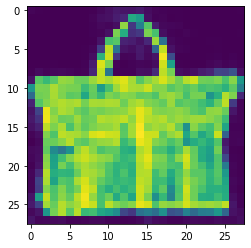

In [40]:
plt.imshow(model.forward(X[2:3]).reshape(28,28).to(torch.device('cpu')).detach().numpy())

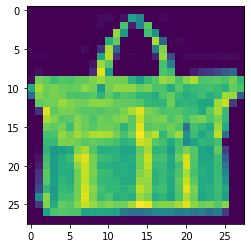

In [38]:
plt.imshow(X[2].reshape(28,28).to(torch.device('cpu')))

# Interpretable embedding

In [60]:
class AUTOENC_LogisticRegression(nn.Module):
    def __init__(self, size):
        super(AUTOENC_LogisticRegression, self).__init__()

        self.lin1 = nn.Linear(784, size)
        self.lin2 = nn.Linear(size, 784)
        
    def forward(self, X):
        X = torch.tanh(self.lin1(X))
        X = torch.sigmoid(self.lin2(X))
        return X
    
    def embed(self, X):
        X = torch.tanh(self.lin1(X))
        return X       

In [61]:
logRegEmb = AUTOENC_LogisticRegression(10).to(device)

In [62]:
opt = optim.Adam(logRegEmb.parameters(), lr=0.001)

In [176]:
EPOCHS=100
for epoch in range(EPOCHS):
    i = 1
    for X, y in tqdm_notebook(dataLoader):
        
        # Reshape
        X = X.reshape(X.shape[0], 784)
        
        # Zero grad
        logRegEmb.zero_grad()
        
        # Restored image
        X_pred = logRegEmb.forward(X)
        
        # Loss
        L = torch.sum((X - X_pred)**2)
        
        # Backpropagation
        L.backward()
        
        # Adam step
        opt.step()

        # Print
        if (i % (len(dataLoader)//10)) == 0: print("Iteration %d \n        L: %.4f" % (i, L))
        i += 1
        
        torch.cuda.empty_cache()

Iteration 3 
        L: 64629.5781
Iteration 6 
        L: 64201.4883
Iteration 9 
        L: 63499.5312
Iteration 12 
        L: 63762.5273
Iteration 15 
        L: 63704.5547
Iteration 18 
        L: 64541.0078
Iteration 21 
        L: 65072.6172
Iteration 24 
        L: 63461.8047
Iteration 27 
        L: 64048.9531
Iteration 30 
        L: 65824.7266
Iteration 33 
        L: 63403.6523


Iteration 3 
        L: 62827.7500
Iteration 6 
        L: 64990.2656
Iteration 9 
        L: 64600.0820
Iteration 12 
        L: 64348.1797
Iteration 15 
        L: 64195.0781
Iteration 18 
        L: 64094.2773
Iteration 21 
        L: 65273.3398
Iteration 24 
        L: 64553.9414
Iteration 27 
        L: 65325.2656
Iteration 30 
        L: 64001.5000
Iteration 33 
        L: 64174.5352


Iteration 3 
        L: 63712.6523
Iteration 6 
        L: 63536.4453
Iteration 9 
        L: 62478.1797
Iteration 12 
        L: 64240.0234
Iteration 15 
        L: 63715.4883
Iteration 18 
        L: 64123.2969
Iteration 21 
        L: 64573.0312
Iteration 24 
        L: 63401.8516
Iteration 27 
        L: 64319.5508
Iteration 30 
        L: 64575.2461
Iteration 33 
        L: 63572.5859


Iteration 3 
        L: 64635.3359
Iteration 6 
        L: 64945.5156
Iteration 9 
        L: 63795.5820
Iteration 12 
        L: 62864.7578
Iteration 15 
        L: 64990.2344
Iteration 18 
        L: 63012.8516
Iteration 21 
        L: 64224.4062
Iteration 24 
        L: 63766.5703
Iteration 27 
        L: 64003.6992
Iteration 30 
        L: 64050.5469
Iteration 33 
        L: 63309.8945


Iteration 3 
        L: 63378.1094
Iteration 6 
        L: 64789.1562
Iteration 9 
        L: 63752.3398
Iteration 12 
        L: 64327.7031
Iteration 15 
        L: 63623.5312
Iteration 18 
        L: 63011.0391
Iteration 21 
        L: 63867.9258
Iteration 24 
        L: 63174.8828
Iteration 27 
        L: 63148.2188
Iteration 30 
        L: 63437.5781
Iteration 33 
        L: 64975.8789


Iteration 3 
        L: 64126.6641
Iteration 6 
        L: 63949.0977
Iteration 9 
        L: 63351.7812
Iteration 12 
        L: 64466.2031
Iteration 15 
        L: 64375.6836
Iteration 18 
        L: 64770.1797
Iteration 21 
        L: 63051.1328
Iteration 24 
        L: 64675.1680
Iteration 27 
        L: 64063.7734
Iteration 30 
        L: 64223.5469
Iteration 33 
        L: 63868.6797


Iteration 3 
        L: 64031.9062
Iteration 6 
        L: 62192.4375
Iteration 9 
        L: 64805.3281
Iteration 12 
        L: 65445.4688
Iteration 15 
        L: 64359.5781
Iteration 18 
        L: 64278.4062
Iteration 21 
        L: 63994.2109
Iteration 24 
        L: 62720.4062
Iteration 27 
        L: 63915.0156
Iteration 30 
        L: 64370.9492
Iteration 33 
        L: 63443.9258


Iteration 3 
        L: 63772.5859
Iteration 6 
        L: 64696.6797
Iteration 9 
        L: 64569.1328
Iteration 12 
        L: 65163.7344
Iteration 15 
        L: 63148.7148
Iteration 18 
        L: 62127.8047
Iteration 21 
        L: 63548.6172
Iteration 24 
        L: 64747.2109
Iteration 27 
        L: 63749.7070
Iteration 30 
        L: 63468.5625
Iteration 33 
        L: 64346.0156


Iteration 3 
        L: 62705.7891
Iteration 6 
        L: 62442.3438
Iteration 9 
        L: 64374.5859
Iteration 12 
        L: 64285.5742
Iteration 15 
        L: 63148.2031
Iteration 18 
        L: 63889.7188
Iteration 21 
        L: 63984.8242
Iteration 24 
        L: 62598.4492
Iteration 27 
        L: 64388.7578
Iteration 30 
        L: 65025.8750
Iteration 33 
        L: 63665.9883


Iteration 3 
        L: 64166.2227
Iteration 6 
        L: 62784.9141
Iteration 9 
        L: 62923.7578
Iteration 12 
        L: 62838.2031
Iteration 15 
        L: 63627.2500
Iteration 18 
        L: 63999.7852
Iteration 21 
        L: 64432.9492
Iteration 24 
        L: 62629.5391
Iteration 27 
        L: 63036.6406
Iteration 30 
        L: 62781.6055
Iteration 33 
        L: 63909.5117


Iteration 3 
        L: 64907.0469
Iteration 6 
        L: 62465.6406
Iteration 9 
        L: 63481.5508
Iteration 12 
        L: 64636.4375
Iteration 15 
        L: 62611.1484
Iteration 18 
        L: 63333.9258
Iteration 21 
        L: 63871.4258
Iteration 24 
        L: 63388.1406
Iteration 27 
        L: 63832.2891
Iteration 30 
        L: 64066.1797
Iteration 33 
        L: 63414.0469


Iteration 3 
        L: 63777.2969
Iteration 6 
        L: 63223.4219
Iteration 9 
        L: 63572.2539
Iteration 12 
        L: 64868.1172
Iteration 15 
        L: 63362.4219
Iteration 18 
        L: 62482.8828
Iteration 21 
        L: 64093.6016
Iteration 24 
        L: 63078.6094
Iteration 27 
        L: 62820.4297
Iteration 30 
        L: 61977.1016
Iteration 33 
        L: 61841.2227


Iteration 3 
        L: 62931.9922
Iteration 6 
        L: 64885.3281
Iteration 9 
        L: 63896.6016
Iteration 12 
        L: 62683.3125
Iteration 15 
        L: 64328.5234
Iteration 18 
        L: 62801.9766
Iteration 21 
        L: 64230.3984
Iteration 24 
        L: 64167.5586
Iteration 27 
        L: 64133.1836
Iteration 30 
        L: 62408.7969
Iteration 33 
        L: 62589.6094


Iteration 3 
        L: 63460.3203
Iteration 6 
        L: 62720.9883
Iteration 9 
        L: 62454.0078
Iteration 12 
        L: 62737.4766
Iteration 15 
        L: 63597.1094
Iteration 18 
        L: 63735.6797
Iteration 21 
        L: 64249.8750
Iteration 24 
        L: 62841.4844
Iteration 27 
        L: 65593.5156
Iteration 30 
        L: 63541.2344
Iteration 33 
        L: 64673.4844


Iteration 3 
        L: 64188.5625
Iteration 6 
        L: 63202.8906
Iteration 9 
        L: 63631.8516
Iteration 12 
        L: 64104.7969
Iteration 15 
        L: 63271.2422
Iteration 18 
        L: 63444.0664
Iteration 21 
        L: 65195.5078
Iteration 24 
        L: 62525.6250
Iteration 27 
        L: 63751.1641
Iteration 30 
        L: 62677.7266
Iteration 33 
        L: 62930.0938


Iteration 3 
        L: 63383.2109
Iteration 6 
        L: 63249.6094
Iteration 9 
        L: 64553.5625
Iteration 12 
        L: 63294.3594
Iteration 15 
        L: 63523.3047
Iteration 18 
        L: 63635.8594
Iteration 21 
        L: 64590.3203
Iteration 24 
        L: 63698.1211
Iteration 27 
        L: 61996.5469
Iteration 30 
        L: 63909.7812
Iteration 33 
        L: 62437.6172


Iteration 3 
        L: 63126.3203
Iteration 6 
        L: 63596.1094
Iteration 9 
        L: 64106.1875
Iteration 12 
        L: 64331.4922
Iteration 15 
        L: 62627.7891
Iteration 18 
        L: 64323.0664
Iteration 21 
        L: 63265.9141
Iteration 24 
        L: 63068.4297
Iteration 27 
        L: 64638.6094
Iteration 30 
        L: 62683.0703
Iteration 33 
        L: 62625.2500


Iteration 3 
        L: 63097.6328
Iteration 6 
        L: 62594.6875
Iteration 9 
        L: 62577.9805
Iteration 12 
        L: 63398.7812
Iteration 15 
        L: 64620.0859
Iteration 18 
        L: 64751.8359
Iteration 21 
        L: 62733.1875
Iteration 24 
        L: 63919.6094
Iteration 27 
        L: 64375.4062
Iteration 30 
        L: 63109.4375
Iteration 33 
        L: 62744.8594


Iteration 3 
        L: 63312.4336
Iteration 6 
        L: 63517.9297
Iteration 9 
        L: 62847.9766
Iteration 12 
        L: 62803.2891
Iteration 15 
        L: 62878.8672
Iteration 18 
        L: 62510.6484
Iteration 21 
        L: 62969.1055
Iteration 24 
        L: 63273.1484
Iteration 27 
        L: 62394.1484
Iteration 30 
        L: 63884.2734
Iteration 33 
        L: 63646.3008


Iteration 3 
        L: 63399.0195
Iteration 6 
        L: 62575.6016
Iteration 9 
        L: 64231.9688
Iteration 12 
        L: 64818.7422
Iteration 15 
        L: 63307.7617
Iteration 18 
        L: 62340.4219
Iteration 21 
        L: 62916.3672
Iteration 24 
        L: 62534.8242
Iteration 27 
        L: 63943.3320
Iteration 30 
        L: 64158.5234
Iteration 33 
        L: 63324.3984


Iteration 3 
        L: 64436.3828
Iteration 6 
        L: 63027.2109
Iteration 9 
        L: 62634.1250
Iteration 12 
        L: 61390.4961
Iteration 15 
        L: 62863.1641
Iteration 18 
        L: 63881.1797
Iteration 21 
        L: 63262.9531
Iteration 24 
        L: 63977.5312
Iteration 27 
        L: 63690.7070
Iteration 30 
        L: 62814.4453
Iteration 33 
        L: 64317.4492


Iteration 3 
        L: 63402.7656
Iteration 6 
        L: 63879.3594
Iteration 9 
        L: 63550.2227
Iteration 12 
        L: 63845.6992
Iteration 15 
        L: 62528.2734
Iteration 18 
        L: 62698.2734
Iteration 21 
        L: 63413.8672
Iteration 24 
        L: 63641.0938
Iteration 27 
        L: 62715.2539
Iteration 30 
        L: 63447.9844
Iteration 33 
        L: 62030.8828


Iteration 3 
        L: 63085.3125
Iteration 6 
        L: 62384.3516
Iteration 9 
        L: 63153.4688
Iteration 12 
        L: 63664.8477
Iteration 15 
        L: 64434.8086
Iteration 18 
        L: 61954.6484
Iteration 21 
        L: 62560.8516
Iteration 24 
        L: 63125.8477
Iteration 27 
        L: 62392.6602
Iteration 30 
        L: 61951.6641
Iteration 33 
        L: 62740.3516


Iteration 3 
        L: 63556.9180
Iteration 6 
        L: 63324.5781
Iteration 9 
        L: 62997.6641
Iteration 12 
        L: 63021.1602
Iteration 15 
        L: 63494.9766
Iteration 18 
        L: 63317.4297
Iteration 21 
        L: 63289.4141
Iteration 24 
        L: 62584.5352
Iteration 27 
        L: 63222.9141
Iteration 30 
        L: 62533.2734
Iteration 33 
        L: 63391.0586


Iteration 3 
        L: 62365.0703
Iteration 6 
        L: 62517.7344
Iteration 9 
        L: 61629.7188
Iteration 12 
        L: 63578.4922
Iteration 15 
        L: 63466.7891
Iteration 18 
        L: 63589.4219
Iteration 21 
        L: 62600.9375
Iteration 24 
        L: 63908.8086
Iteration 27 
        L: 62933.8672
Iteration 30 
        L: 63205.3203
Iteration 33 
        L: 63774.2383


Iteration 3 
        L: 63089.4453
Iteration 6 
        L: 62442.9688
Iteration 9 
        L: 62786.5938
Iteration 12 
        L: 61560.0039
Iteration 15 
        L: 62928.9648
Iteration 18 
        L: 62251.7148
Iteration 21 
        L: 62464.3281
Iteration 24 
        L: 63078.9180
Iteration 27 
        L: 62355.9297
Iteration 30 
        L: 63371.7422
Iteration 33 
        L: 62784.4844


Iteration 3 
        L: 63377.8984
Iteration 6 
        L: 62772.4961
Iteration 9 
        L: 63463.9922
Iteration 12 
        L: 62654.1016
Iteration 15 
        L: 63546.9609
Iteration 18 
        L: 63779.1719
Iteration 21 
        L: 62821.7031
Iteration 24 
        L: 61534.3516
Iteration 27 
        L: 62459.2422
Iteration 30 
        L: 63117.4297
Iteration 33 
        L: 63558.6328


Iteration 3 
        L: 63261.5938
Iteration 6 
        L: 63007.8984
Iteration 9 
        L: 62639.3164
Iteration 12 
        L: 62189.8438
Iteration 15 
        L: 61825.1211
Iteration 18 
        L: 62616.1406
Iteration 21 
        L: 62950.2422
Iteration 24 
        L: 64110.5977
Iteration 27 
        L: 60978.9141
Iteration 30 
        L: 62915.2188
Iteration 33 
        L: 62261.3984


Iteration 3 
        L: 61828.1172
Iteration 6 
        L: 62831.3438
Iteration 9 
        L: 63889.6875
Iteration 12 
        L: 62877.4297
Iteration 15 
        L: 62889.7539
Iteration 18 
        L: 62063.0781
Iteration 21 
        L: 62340.2539
Iteration 24 
        L: 62373.2500
Iteration 27 
        L: 63109.6016
Iteration 30 
        L: 64275.1953
Iteration 33 
        L: 63012.1094


KeyboardInterrupt: 

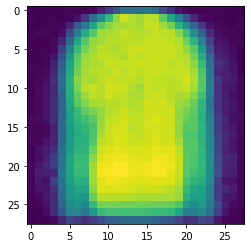

In [101]:
plt.imshow(logRegEmb.forward(X[2:3]).reshape(28,28).to(torch.device('cpu')).detach().numpy())

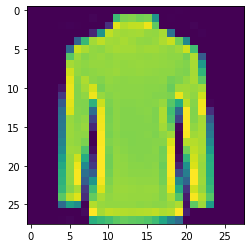

In [102]:
plt.imshow(X[2].reshape(28,28).to(torch.device('cpu')))

In [103]:
for X, y in dataLoader:
    print(X.reshape(X.shape[0], 784).shape)
    print(y.shape)
    break

torch.Size([2000, 784])
torch.Size([2000])


In [104]:
logRegEmb.lin1.weight[0].reshape(28,28).to(torch.device('cpu')).detach().numpy()

array([[-3.05975527e-02, -3.45478766e-02, -2.37458460e-02,
        -1.38977971e-02, -1.68014914e-02,  2.64312271e-02,
         1.95793100e-02,  5.97951524e-02,  2.83828657e-02,
         4.54375297e-02,  9.23008099e-02,  4.42997850e-02,
         1.01675019e-01,  8.67561027e-02,  8.61105770e-02,
         4.36138846e-02,  4.35404256e-02,  6.61387742e-02,
         3.00417710e-02,  4.93134819e-02,  6.14792183e-02,
         7.75699690e-02,  7.35269189e-02,  9.33022797e-02,
         4.61616628e-02, -9.61939618e-03,  2.31071468e-02,
        -2.01751981e-02],
       [ 1.31771006e-02, -2.62331050e-02, -2.37701852e-02,
        -4.26320396e-02, -2.11734343e-02,  4.56598848e-02,
         5.26814424e-02,  3.77968810e-02,  3.41493972e-02,
         1.32425511e-02,  1.20708663e-02,  6.34139776e-02,
         4.79151644e-02,  9.90187526e-02,  7.92367384e-02,
         1.06560089e-01,  8.67056996e-02,  5.57802543e-02,
         1.29322931e-02,  5.36087528e-02,  6.62334934e-02,
         7.34605268e-02,  1.19

In [187]:
def plot_logregemb(emb, size):
    fig, ax = plt.subplots(10, figsize=(20,20))
    for i in range(size):
        ax[i].imshow(logRegEmb.lin1.weight[i].reshape(28,28).to(torch.device('cpu')).detach().numpy())

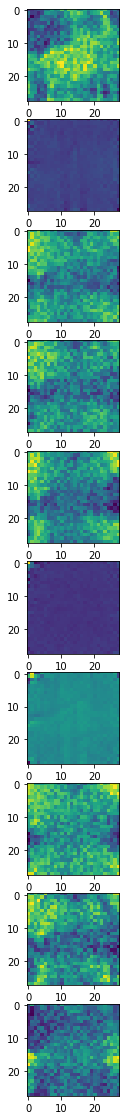

In [188]:
plot_logregemb(logRegEmb, 10)

# SVD

$ SVD: X = U S V^T $

In [110]:
X = X.reshape(2000, 784)

In [112]:
U, S, V = torch.svd(X)

In [127]:
S.shape

torch.Size([784])

In [118]:
((U * S) @ V.T - X).sum()

tensor(-0.0857, device='cuda:0')

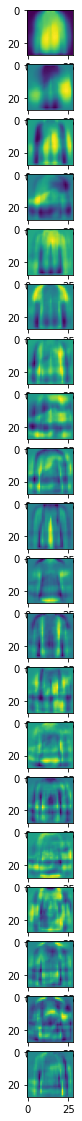

In [128]:
fig, ax = plt.subplots(20, figsize=(20,20))
for i in range(20):
    ax[i].imshow(V[:,i].reshape(28,28).to(torch.device('cpu')))

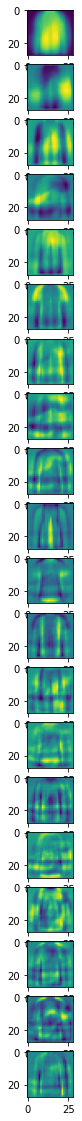

In [175]:
inV = torch.inverse(V.T)
fig, ax = plt.subplots(20, figsize=(20,20))
for i in range(20):
    ax[i].imshow(inV[:,i].reshape(28,28).to(torch.device('cpu')))

In [133]:
torch.unique(y, return_counts=True)

(tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], device='cuda:0'),
 tensor([202, 171, 203, 198, 221, 225, 219, 193, 167, 201], device='cuda:0'))

In [135]:
X.shape

torch.Size([2000, 784])

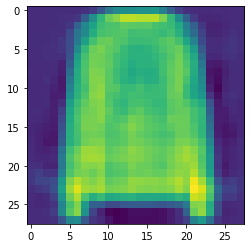

In [186]:
plt.imshow(((X @ torch.inverse(V.T))[:,:30] @ V[:, :30].T)[0].reshape(28,28).to(torch.device('cpu')))

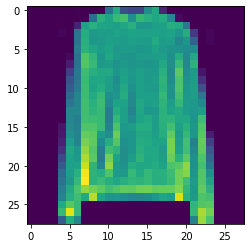

In [179]:
plt.imshow(X[0].reshape(28,28).to(cpu))